# Experiment with the mnist fashion data set

**CUDA NOTE:** remember to shut down the other kernels; othewise, they'll still be taking up GPU memory!

It is very similar to the mnist digit data set.  It has 10 categories of black and white images. 

* 0 = t-shirt
* 1 = trouser
* 2 = pullover
* 3 = dress
* 4 = coat
* 5 = sandal
* 6 = shirt
* 7 = sneaker
* 8 = bag
* 9 = ankle boot

In [33]:
from aitk.utils import gallery, array_to_image
from aitk.networks import Network

%matplotlib widget

import tensorflow
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

label_map = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot']

# Get the data
* Download the data
* Explore what you have

In [34]:
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()

In [35]:
train_x.shape

(60000, 28, 28)

In [36]:
test_x.shape

(10000, 28, 28)

In [37]:
images = [array_to_image(train_x[i]) for i in range(10)]
bigger = [image.resize((100,100)) for image in images]

9,0,0,3,0
2,7,2,5,5

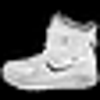
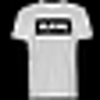
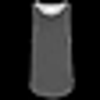
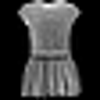
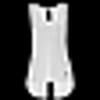
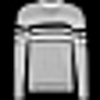
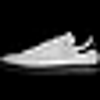
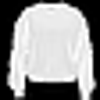
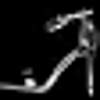
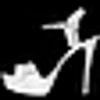

In [38]:
gallery(bigger, gallery_shape=(5,2), labels=train_y[:10])

In [39]:
train_y[:20]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4],
      dtype=uint8)

# Prepare the data for the network
* You may need to normalize the inputs so that they are in the range [0,1].
* You may need to convert the targets so that they are represented as one-hot vectors when you are doing categorization.

### Input data

In [40]:
min_input = train_x.min()
max_input = train_x.max()
print("range of input values is:", min_input, max_input)

range of input values is: 0 255


In [41]:
train_x_normalized = (train_x - min_input)/(max_input - min_input)

In [42]:
test_x_normalized = (test_x - min_input)/(max_input - min_input)

### Data sent into a Conv2D layer must have a depth
* This may require you to do a reshape command.
* For these black and white images there is only one channel of information.
* For color images there are typically 3 channels (Red, Green, Blue)

In [43]:
train_x_normalized = train_x_normalized.reshape(60000,28,28,1)
test_x_normalized = test_x_normalized.reshape(10000,28,28,1)

### Target data

In [44]:
num_categories = len(set(train_y))

In [45]:
train_y_category = to_categorical(train_y, num_categories)

In [46]:
test_y_category = to_categorical(test_y, num_categories)

In [47]:
train_y_category[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

# Construct the model

This is just one possible configuration of layers to learn the data set.  You should experiment with the number of filters, the filter size, and the layers themselves. However, be sure to leave the output layer's activation function as `softmax`.

You should explicitly name each layer so that it will be easier to inspect them later. Use a clear naming convention.  For example the first convolution layer might be "conv1", the next "conv2", and so on.

In [145]:
neural_net = Sequential()
neural_net.add(Conv2D(40,(3,3),name="conv1", activation="relu",input_shape=(28,28,1)))
neural_net.add(Conv2D(60,(3,3),name="conv2", activation="relu"))
neural_net.add(Conv2D(80,(3,3),name="conv3", activation="relu"))
neural_net.add(MaxPooling2D(pool_size=(2,2),name="pool1"))
neural_net.add(Flatten(name="flatten1"))
neural_net.add(Dense(100, name="hidden1", activation='relu'))
neural_net.add(Dense(10, name="output",activation='softmax'))

# Compile the model

For categorical data like handwritten digits we typically use a loss function called `categorical_crossentropy` and should be used in conjunction with the `softmax` activation function at the output layer.  This interprets the outputs as representing probabilities and forces them to sum to 1.0.  Thus the output from the network will reflect how likely it considers a particular input to be a member of one of the output categories.

In [146]:
neural_net.compile(optimizer="SGD", loss="categorical_crossentropy",
                   metrics=['accuracy'])

# Create an aitk Network
This allows us to do more visualization of what is happening inside the network.

In [147]:
net = Network(neural_net)
net.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 26, 26, 40)        400       
                                                                 
 conv2 (Conv2D)              (None, 24, 24, 60)        21660     
                                                                 
 conv3 (Conv2D)              (None, 22, 22, 80)        43280     
                                                                 
 pool1 (MaxPooling2D)        (None, 11, 11, 80)        0         
                                                                 
 flatten1 (Flatten)          (None, 9680)              0         
                                                                 
 hidden1 (Dense)             (None, 100)               968100    
                                                                 
 output (Dense)              (None, 10)               

In [148]:
# from time import sleep
# for i in range(10):
#     net.propagate(train_x_normalized[i])
#     # net.display(train_x_normalized[i])
#     sleep(1.0)

# Train the model

In [149]:
history = net.fit(train_x_normalized, 
                  train_y_category, 
                  verbose=1,
                  validation_data=(test_x_normalized, 
                                   test_y_category),
                  epochs=10)

Epoch 10/10 loss: 0.20810674130916595 - accuracy: 0.9238499999046326 - val_loss: 0.2768903970718384 - val_accuracy: 0.9014999866485596


# Evaluate training curves

Look at the curves for both the loss function and the model accuracy.  Here are some things to look for:
* Do decreases in the loss function seem to correspond well with increases in accuracy?  
* Does the model appear to be under trained (i.e. both train and test performance looks like it might continue to get better with more epochs)?  
* Does it appear to be over trained (i.e. train performance keeps getting better, but test performance is getting worse as epochs increase)?
* Are there signs of significant overfitting (i.e. train performance is much higher than test performance, likely worsening as epochs increase)?

# Inspect the feature maps

We can ask the network to propagate to specific layers and inspect the representations created there to try to understand how it has solved the problem. First we need to set up the color maps to display properly by finding the maximum possible value using a particular test image.

In [150]:
test_image = 100 # change this to see a different image 

In [151]:
from math import ceil
for layer in ["conv1","conv2","conv3","pool1"]:
    data = [net.propagate_to(test_x_normalized[test_image], layer, channel=channel)
            for channel in range(8)]
    largest = max([sublist.max() for sublist in data])
    net.set_config_layer(layer, colormap=("gray", 0, ceil(largest)))

channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8

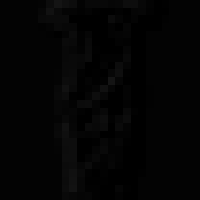
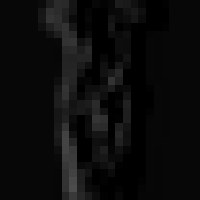
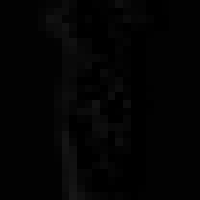
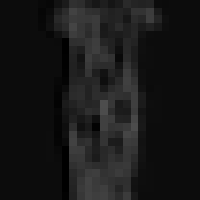
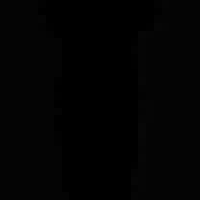
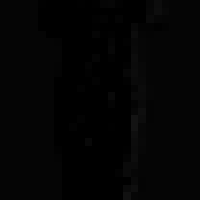
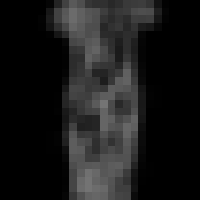
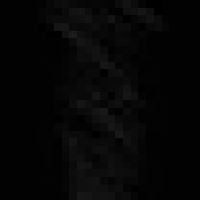

In [152]:
images = [net.propagate_to(test_x_normalized[test_image], "conv1", "image", channel=channel)
         for channel in range(8)]
original = test_x_normalized[test_image]
bigger = [image.resize((200,200),resample=0) for image in images]
gallery([original] + bigger, labels="channel{index}", gallery_shape=(9,1))

channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8

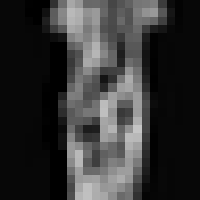
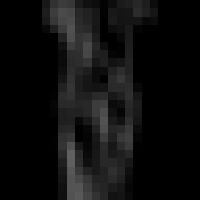
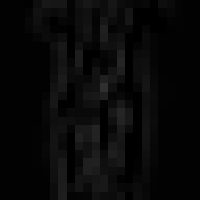
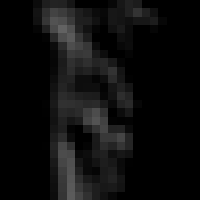
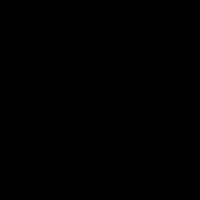
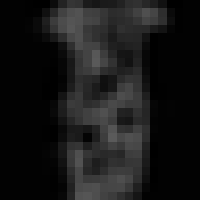
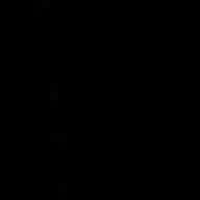
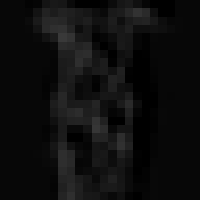

In [153]:
images = [net.propagate_to(test_x_normalized[test_image], "conv2", "image", channel=channel)
         for channel in range(8)]
original = test_x_normalized[test_image]
bigger = [image.resize((200,200),resample=0) for image in images]
gallery([original] + bigger, labels="channel{index}", gallery_shape=(9,1))

channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8

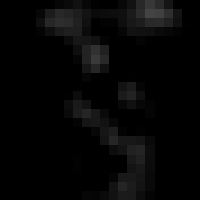
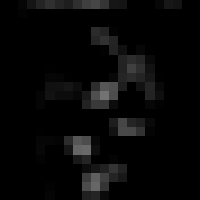
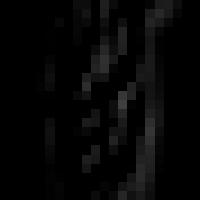
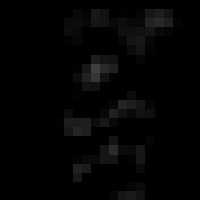
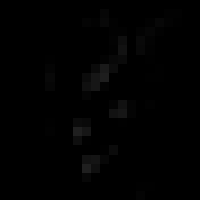
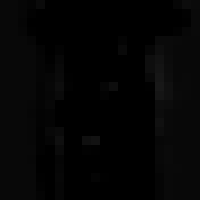
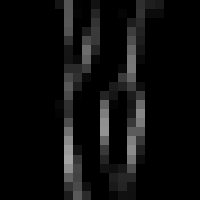
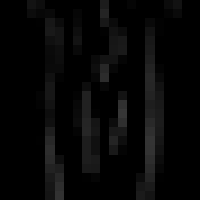

In [154]:
images = [net.propagate_to(test_x_normalized[test_image], "conv3", "image", channel=channel)
         for channel in range(8)]
original = test_x_normalized[test_image]
bigger = [image.resize((200,200),resample=0) for image in images]
gallery([original] + bigger, labels="channel{index}", gallery_shape=(9,1))

channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8

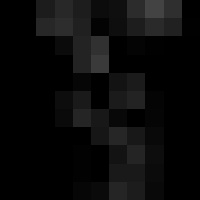
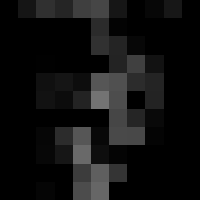
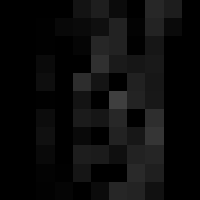
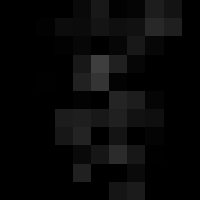
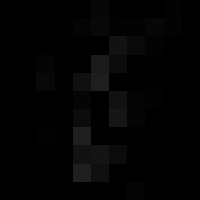
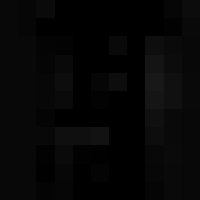
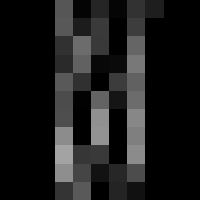
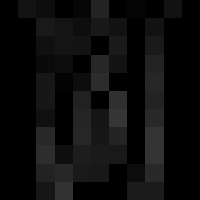

In [158]:
images = [net.propagate_to(test_x_normalized[test_image], "pool1", "image", channel=channel)
         for channel in range(8)]
original = test_x_normalized[test_image]
bigger = [image.resize((200,200),resample=0) for image in images]
gallery([original] + bigger, labels="channel{index}", gallery_shape=(9,1))

# Examine the results
Check which inputs the network is getting wrong. Recall that there are 10 thousand test images.

In [159]:
from numpy import argmax
outputs = net.predict(test_x_normalized)
answers = [argmax(output) for output in outputs]
targets = [argmax(target) for target in test_y_category]

2024-03-31 16:57:10.880696: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.75GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


In [160]:
incorrect = [i for i in range(len(answers)) if answers[i] != targets[i]]
len(incorrect)

986

In [161]:
missed_target = [targets[i] for i in incorrect]
wrong_answer = [answers[i] for i in incorrect]

Let's find out which target classifications are most frequently missed.

In [162]:
from collections import Counter

In [163]:
t_ctr = Counter(missed_target)
t_ctr.most_common()

[(6, 346),
 (2, 214),
 (3, 108),
 (0, 92),
 (4, 83),
 (9, 44),
 (7, 36),
 (1, 26),
 (8, 24),
 (5, 13)]

Let's find out which wrong classification is most frequently given.

In [164]:
a_ctr = Counter(wrong_answer)
a_ctr.most_common()

[(4, 302),
 (0, 200),
 (6, 182),
 (2, 90),
 (3, 79),
 (7, 50),
 (8, 26),
 (5, 24),
 (9, 24),
 (1, 9)]

In [165]:
images = [array_to_image(test_x[index]) for index in incorrect]
label = [str(missed_target[i]) + "," + str(wrong_answer[i]) for i in range(len(wrong_answer))]
gallery(images, labels=label)

"9,5","6,0","3,6","2,6","4,6","3,4","9,7","2,4","6,2","4,2","9,7","6,4","2,6","6,3","4,3","1,3","2,3","6,4","6,2","2,6","2,4","3,4","6,4","6,0","3,4","9,7","6,4","0,6","6,0","2,6","4,3","0,6"
"2,0","6,2","4,6","4,3","6,0","9,7","6,4","0,6","2,4","3,0","6,0","4,6","8,0","4,2","2,4","6,4","4,6","6,0","6,0","6,0","3,6","6,0","6,0","6,3","3,6","6,0","6,4","8,0","4,2","1,3","2,6","0,3"
"3,6","9,7","6,3","5,7","6,4","2,0","3,0","2,6","1,3","4,6","2,4","6,2","2,6","0,6","3,1","2,4","6,2","6,4","0,6","0,8","6,2","3,0","0,6","2,4","6,0","3,0","3,8","4,2","0,6","6,4","6,4","4,6"
"6,0","8,6","4,6","0,3","6,0","6,4","0,6","4,6","6,0","4,3","6,4","6,4","6,0","2,6","2,6","6,4","6,3","0,3","4,6","0,6","6,0","6,0","6,4","2,4","6,0","2,4","6,0","8,5","0,6","6,4","3,6","3,4"
"3,6","2,3","4,2","2,4","6,0","4,6","2,6","2,4","8,4","4,6","6,2","9,7","6,2","5,7","0,3","2,0","9,7","2,6","2,6","2,4","8,1","0,2","2,6","5,7","6,0","2,6","2,4","9,7","6,4","6,8","6,0","2,4"
"3,4","3,6","3,4","6,0","2,4","2,4","6,0","8,3","3,4","4,3","2,4","3,4","6,4","3,4","6,0","0,3","5,7","9,7","2,4","2,6","3,0","6,0","8,2","2,4","6,0","6,0","2,4","7,9","5,7","2,4","2,6","3,4"
"3,4","2,6","2,6","6,4","4,6","6,4","2,4","6,4","3,4","4,6","6,0","6,0","6,2","3,4","0,3","8,4","2,6","2,4","6,0","2,4","6,0","6,4","3,2","2,4","2,4","1,6","6,0","9,5","6,0","2,6","6,0","3,4"
"8,7","6,0","6,4","8,2","1,3","6,0","4,6","2,4","0,6","3,4","4,2","9,7","6,4","2,6","6,4","0,6","6,0","0,6","2,6","2,6","0,8","6,2","2,0","4,6","0,2","6,3","3,4","0,6","6,2","6,0","3,6","6,4"
"0,6","3,6","2,6","1,0","4,6","4,3","4,6","3,4","3,8","3,4","6,0","6,0","6,4","6,0","3,0","0,2","6,4","4,6","2,4","0,8","3,4","3,4","8,3","0,6","7,9","3,4","4,6","2,4","2,4","9,7","6,2","1,3"
"0,2","2,6","7,9","3,0","6,2","6,0","3,4","7,5","8,0","3,2","6,0","0,8","6,1","3,6","6,0","4,3","6,0","3,4","6,4","0,2","3,0","6,2","6,2","2,4","6,4","3,0","4,8","6,0","0,8","2,6","2,0","6,4"
"2,0","6,4","3,4","2,4","2,6","3,2","3,0","6,0","6,0","6,3","6,4","7,9","0,6","2,4","2,4","6,4","6,4","6,0","6,0","0,6","2,6","2,3","2,6","0,8","8,7","3,6","6,0","2,3","2,4","6,0","3,4","7,9"


### Confusion matrix 
Let's also build a confusion matrix to get a more precise idea of what mistakes are being made

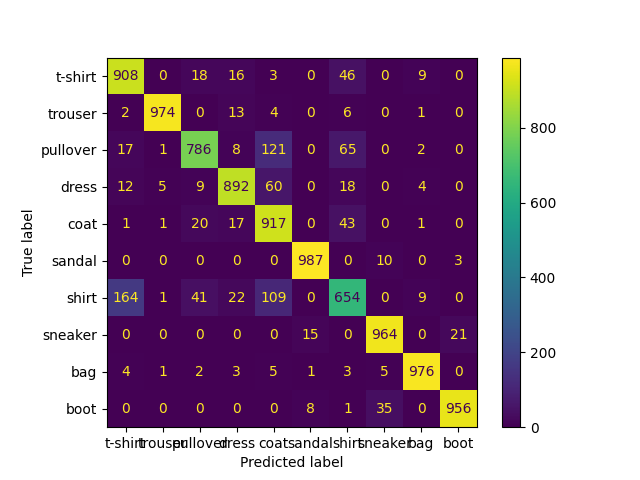

In [166]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib widget

cm = confusion_matrix(targets, answers)
cm_plt = ConfusionMatrixDisplay(cm, display_labels=label_map)
cm_plt.plot()

# Analysis and Improvement

What sorts of mistakes are being made?  Do they make sense?  What sorts of things could you do to improve matters?

Notice here that some classes are performing a lot better than others; in particluar, the 'shirt' class seems to have a lot of overlap with 't-shirt', 'pull-over', and 'coat'.  'coat' and 'pullover' also seem to be easily confused.  

One possible thing to consider would be dropping and/or merging some of these classes if they seem like they really aren't distinct, but keep in mind that if you modify the data (or ideally, modify a *copy* of the data), you'll also need to modify the network and the labels to match, or nothing will work right.
